In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days
0,2,0,25,10,4,755597,4,124962,44.0,45.0,5112.0,0,1879
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,0,1879
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1,1879
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1,1879
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,0,1879


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days
0,2,0,25,10,4,755597,4,124962,44.0,45.0,5112.0,1879
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,1879
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1879
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1879
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,1879


In [4]:
#Feature Selection using SelectKBest
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k=12)
X_select = selection.fit_transform(X,y)
X = X[X.columns[selection.get_support()]]
print(len(X.columns))
list(X.columns)

12


['telecom_partner',
 'gender',
 'age',
 'state',
 'city',
 'pincode',
 'num_dependents',
 'estimated_salary',
 'calls_made',
 'sms_sent',
 'data_used',
 'tenure_days']

In [5]:
# Class Distribution Before SMOTEENN
print("Class distribution before SMOTEENN:", Counter(y))

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X, y)

# Class Distribution After SMOTEENN
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution before SMOTEENN: Counter({0: 194726, 1: 48827})
Class distribution after SMOTEENN: Counter({1: 126156, 0: 80113})


In [6]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X_train_resampled)


In [7]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [8]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (165015, 12)
X_test shape: (41254, 12)


In [9]:
#List to store models
models = []

In [10]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)    
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
    
    plt.figure(figsize=(12,6))
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()

Precision:  0.6661398289326887
Recall:  0.8519281835836867
F1 Score:  0.7476651767856832
ROC AUC Score:  0.6603778267860082


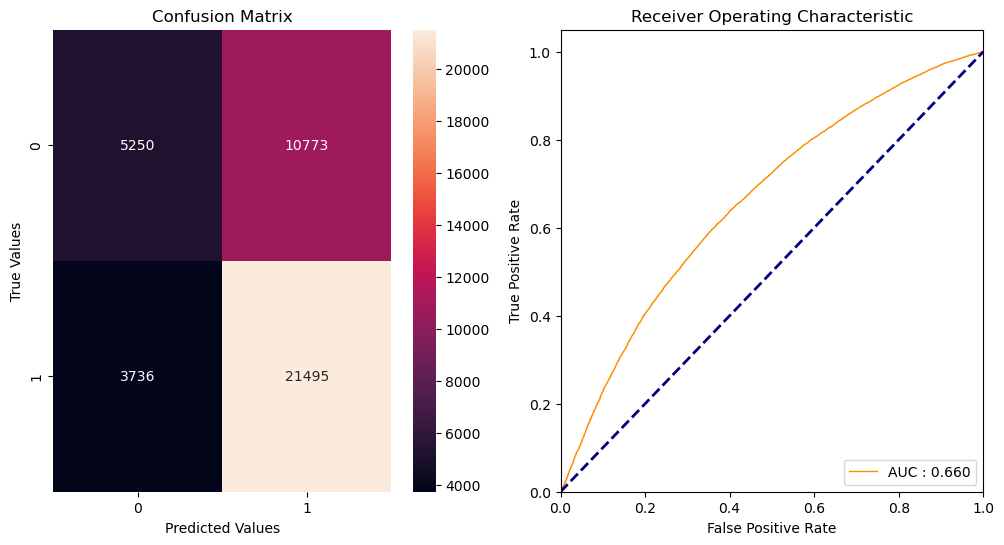

In [11]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision:  0.7655212580081537
Recall:  0.7814196821370536
F1 Score:  0.7733887733887734
ROC AUC Score:  0.7022619848618239


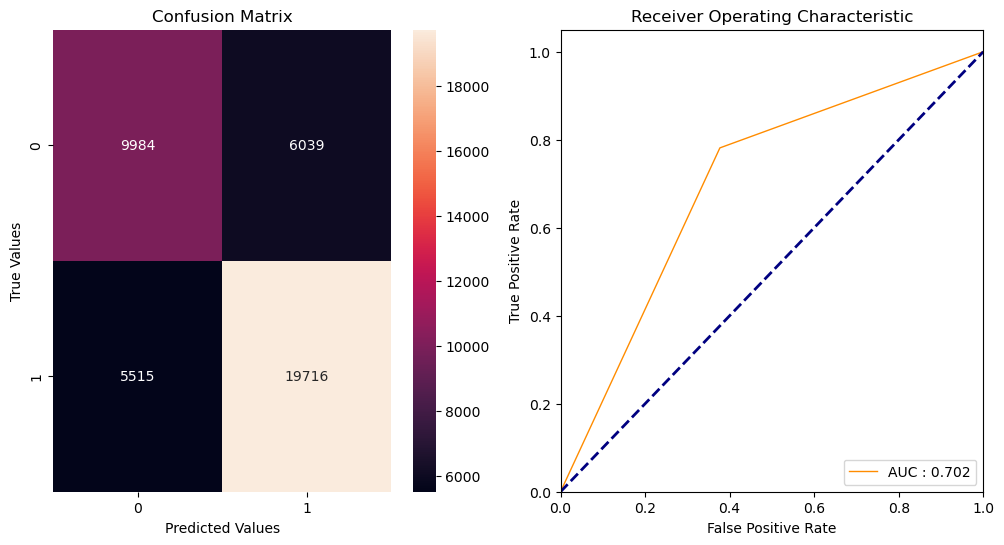

In [12]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision:  0.7076510866329264
Recall:  0.8478855376322778
F1 Score:  0.7714471169449353
ROC AUC Score:  0.7416835029857414


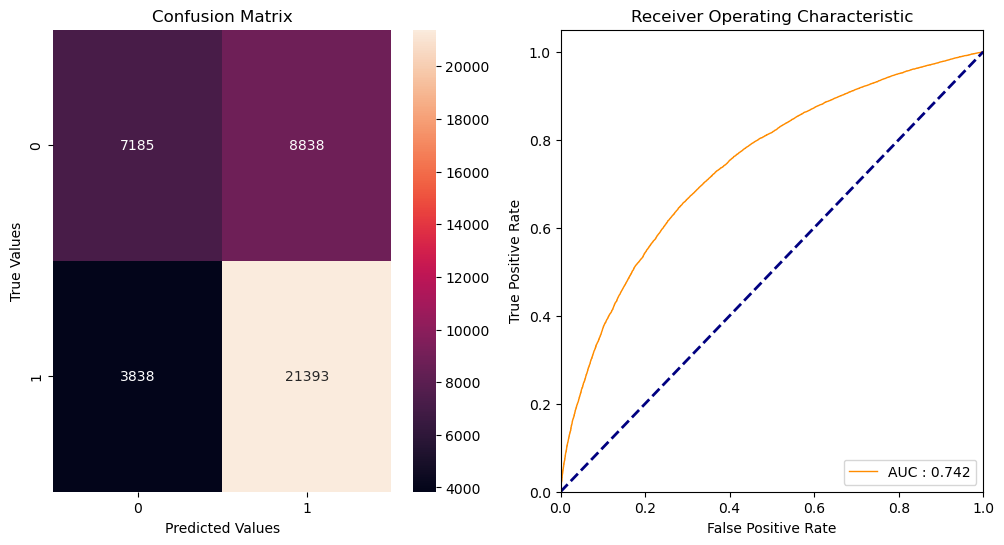

In [13]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision:  0.7984043365399298
Recall:  0.8289405889580278
F1 Score:  0.8133859645711397
ROC AUC Score:  0.838034063845833


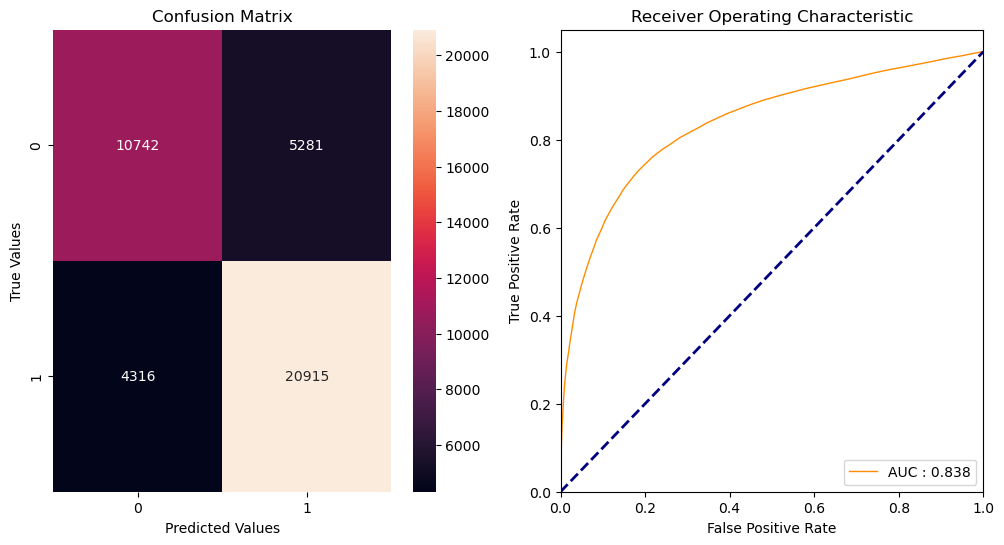

In [14]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision:  0.7360563188681812
Recall:  0.8577939835916135
F1 Score:  0.7922760135444312
ROC AUC Score:  0.7957532105028375


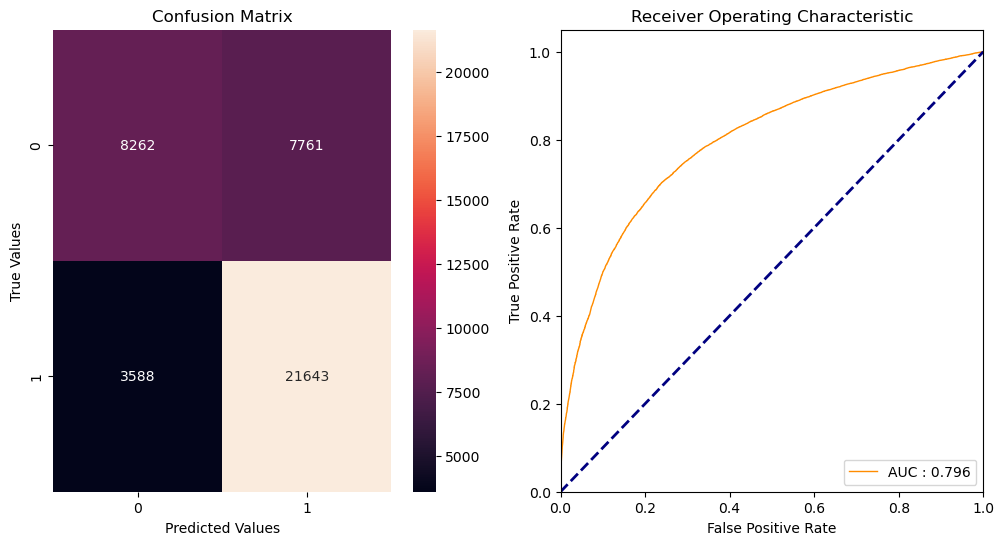

In [15]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision:  0.8741643727880456
Recall:  0.7929531132337204
F1 Score:  0.8315806974520968
ROC AUC Score:  0.8795348640670917


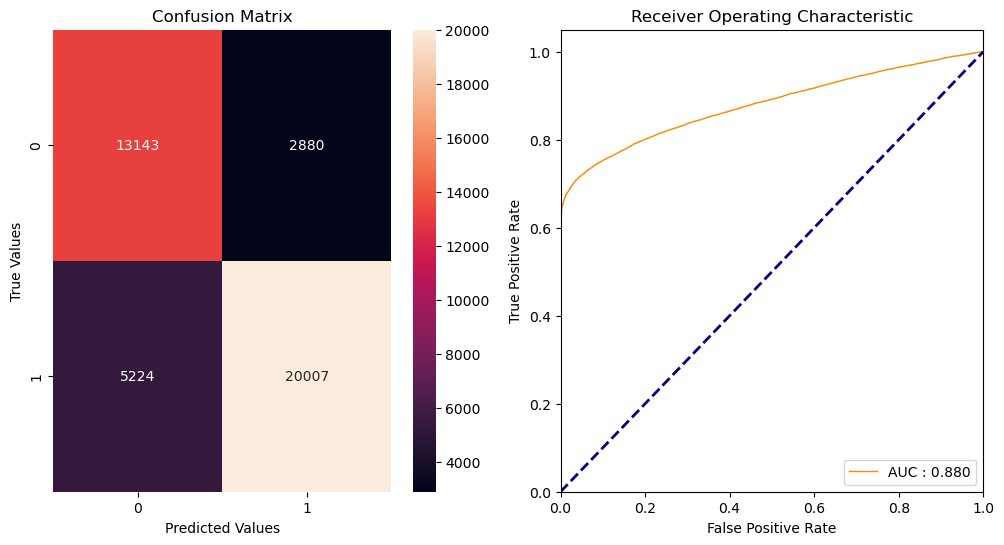

In [16]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [17]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall", "F1"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
    cv_f1_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="f1", n_jobs=-1)


    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2),
                                    round(cv_f1_results.mean() * 100, 2)
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

                    Algorithm  AUC Mean  Bal Acc Mean  Recall     F1
5               XGBClassifier     87.41         79.24   79.83  82.56
3      RandomForestClassifier     82.24         73.44   81.63  80.15
4  GradientBoostingClassifier     79.99         68.82   85.69  79.27
2                  GaussianNB     74.06         64.71   84.69  77.07
1      DecisionTreeClassifier     69.03         69.03   76.79  76.26
0          LogisticRegression     66.21         59.11   85.11  74.79


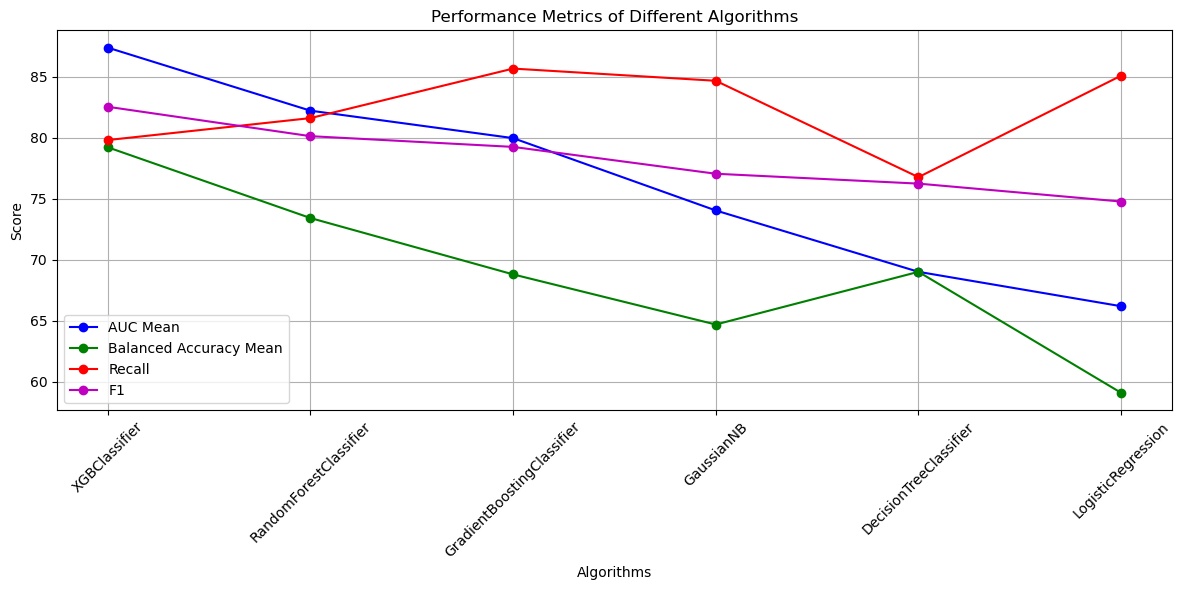

In [18]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r'),
plt.plot(model_results['Algorithm'], model_results['F1'], marker='o', label='F1', color='m')

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    n_iter=10,
    scoring='roc_auc', 
    cv=skf, 
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'ccp_alpha': 0.0}
Best Score for RF: 0.8188936306840343


In [20]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

Random Forest Model Evaluation:
Precision:  0.8040173512055961
Recall:  0.8154254686694938
F1 Score:  0.8096812278630461
ROC AUC Score:  0.8332923403306094


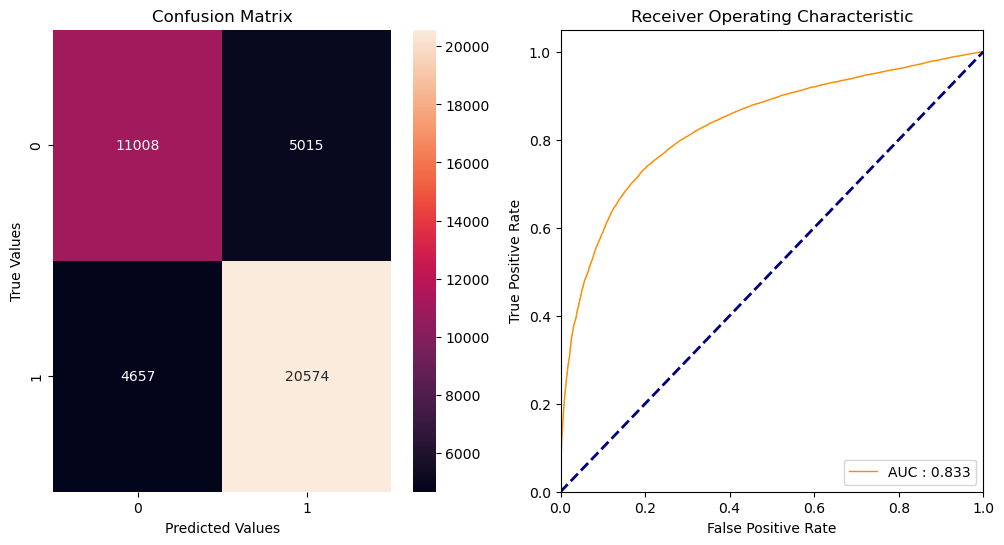

In [21]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

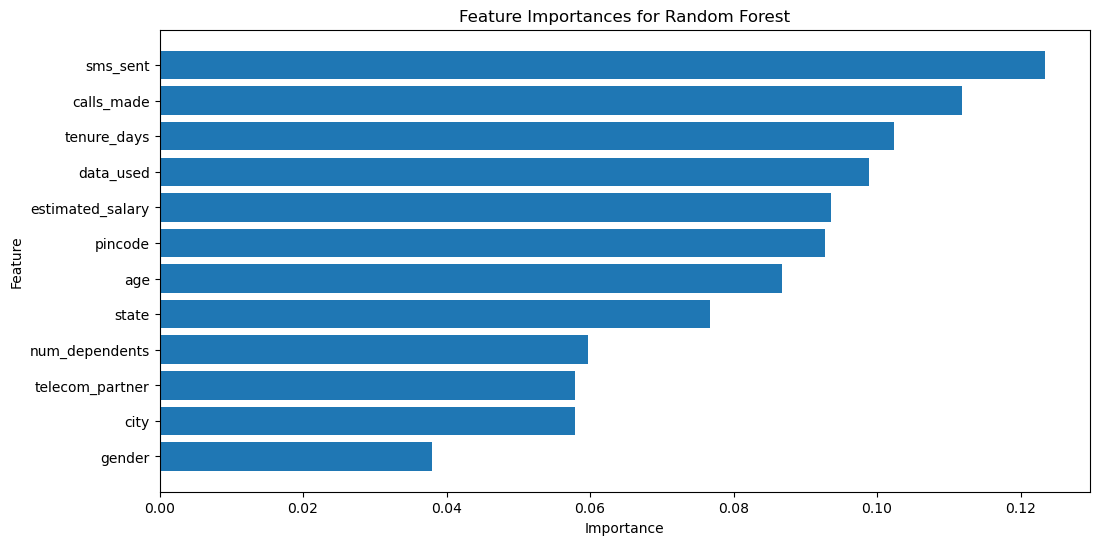

In [22]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [23]:
# Define hyperparameter search space
xgb_params_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 6, 10],  
    'gamma': [0, 0.1, 0.5], 
    'reg_lambda': [1, 5, 10],  
    'scale_pos_weight': [1, 10, 25],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize base model
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)

# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=10,  # Randomly search 10 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 0.6, 'scale_pos_weight': 25, 'reg_lambda': 10, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}
Best Score for XGBoost: 0.8851949938351044


In [24]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  gamma=best_params['gamma'],
                                  reg_lambda=best_params['reg_lambda'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  seed=42,
                                  n_jobs=-1
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost Model Evaluation:
Precision:  0.6603442693718973
Recall:  0.9700368594189688
F1 Score:  0.7857773497070392
ROC AUC Score:  0.8926951886493534


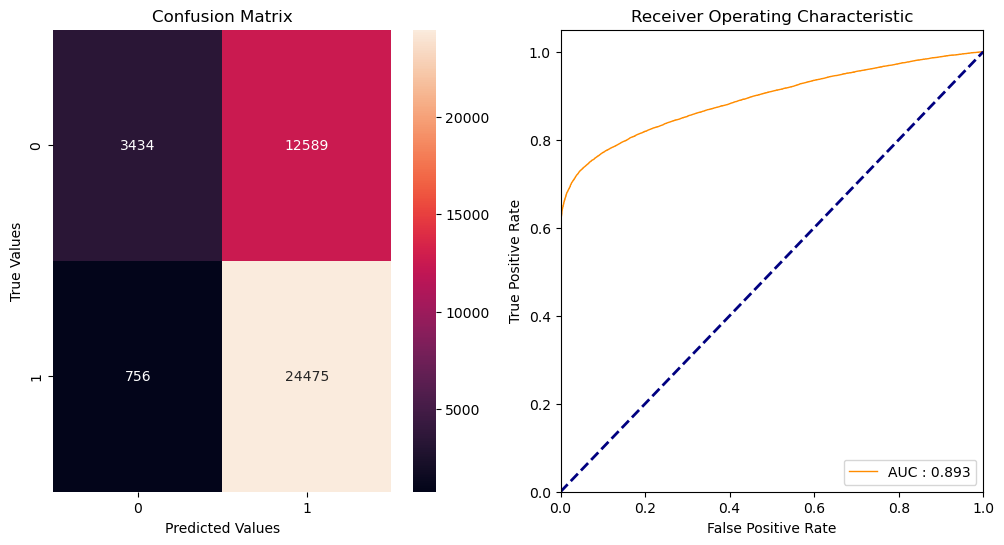

In [25]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

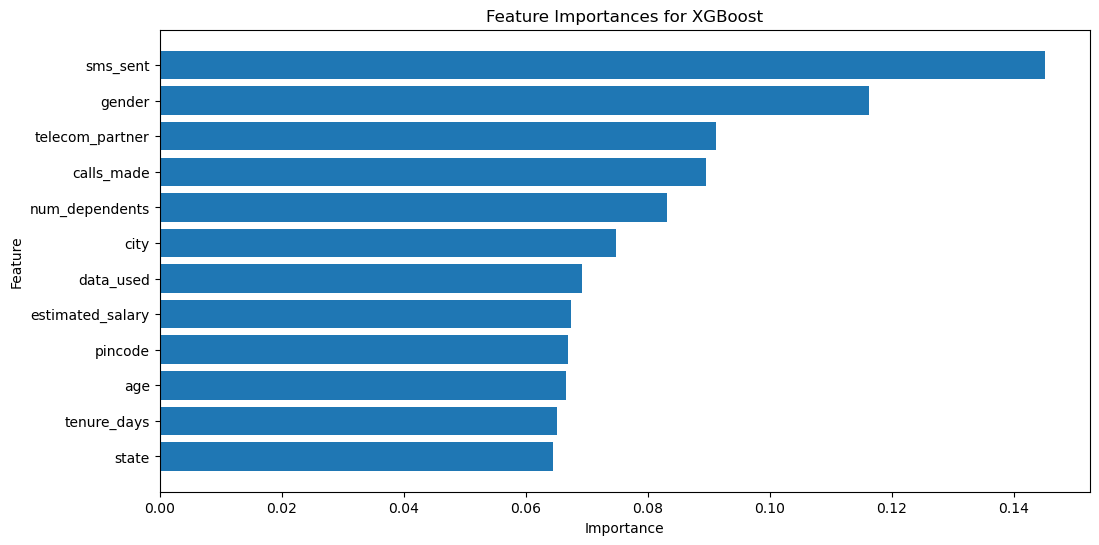

In [26]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [27]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [28]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))